In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import re
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

/Users/jeffwang/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('data/ckd.csv', index_col=0)
df.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'abnormal_red_blood_cells',
              'abnormal_pus_cell', 'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea',
              'serum_creatinine', 'sodium', 'potassium', 'haemoglobin', 'packed_cell_volume', 
              'white_blood_cell_count', 'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 
              'coronary_artery_disease', 'poor_appetite', 'pedal_edema', 'anemia', 'class']
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [31]:
df.isna().sum()

age                           9
blood_pressure               12
specific_gravity             47
albumin                      46
sugar                        49
abnormal_red_blood_cells    152
abnormal_pus_cell            65
pus_cell_clumps               4
bacteria                      4
blood_glucose_random         44
blood_urea                   19
serum_creatinine             17
sodium                       87
potassium                    88
haemoglobin                  52
packed_cell_volume           71
white_blood_cell_count      106
red_blood_cell_count        131
hypertension                  2
diabetes_mellitus             2
coronary_artery_disease       2
poor_appetite                 1
pedal_edema                   1
anemia                        1
class                         0
source                        0
dtype: int64

In [3]:
df['packed_cell_volume'] = pd.to_numeric(df['packed_cell_volume'], errors='coerce')
df['white_blood_cell_count'] = pd.to_numeric(df['white_blood_cell_count'], errors='coerce')
df['red_blood_cell_count'] = pd.to_numeric(df['red_blood_cell_count'], errors='coerce')
df['diabetes_mellitus'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)
df['coronary_artery_disease'] = df['coronary_artery_disease'].replace(to_replace = '\tno', value='no')
df['class'] = df['class'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

categorical_columns = ['abnormal_red_blood_cells', 'abnormal_pus_cell', 'pus_cell_clumps', 
                       'bacteria', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 
                       'poor_appetite', 'pedal_edema', 'anemia', 'class']

replace_dict = {'normal': 0, 'abnormal': 1, 'notpresent': 0, 'present': 1, 'no': 0, 'yes': 1,
               'good': 0, 'poor': 1, 'not ckd': 0, 'ckd': 1}

for column in categorical_columns:
    df[column] = df[column].replace(replace_dict)

In [4]:
df_knn = pd.get_dummies(df.drop(columns=['class']), dummy_na=True)
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
knn_imputer = KNNImputer(n_neighbors=3)
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)
df_knn_imputed = scaler.inverse_transform(df_knn_imputed)
df_knn_imputed = pd.DataFrame(df_knn_imputed, columns=df_knn.columns)
df_knn_imputed['class'] = df['class']
df_knn_imputed[categorical_columns] = df_knn_imputed[categorical_columns].round(0)
df_knn_imputed.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.000000,36.0,1.2,139.333333,4.600000,15.4,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,103.333333,18.0,0.8,141.000000,4.333333,11.3,38.0,6000.0,5.733333,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.000000,53.0,1.8,138.666667,4.866667,9.6,31.0,7500.0,2.833333,0.0,1.0,0.0,1.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,1.0,0.0,0.0,1.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.000000,26.0,1.4,138.666667,4.300000,11.6,35.0,7300.0,4.600000,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
df_knn_imputed.to_csv('data/ckd_clean.csv', index=False)

In [6]:
df_clean = pd.read_csv('data/ckd_clean.csv')
df_clean.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.000000,36.0,1.2,139.333333,4.600000,15.4,44.0,7800.0,5.200000,1.0,1.0,0.0,0.0,0.0,0.0,1
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,103.333333,18.0,0.8,141.000000,4.333333,11.3,38.0,6000.0,5.733333,0.0,0.0,0.0,0.0,0.0,0.0,1
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.000000,53.0,1.8,138.666667,4.866667,9.6,31.0,7500.0,2.833333,0.0,1.0,0.0,1.0,0.0,1.0,1
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,1.0,0.0,0.0,1.0,1.0,1.0,1
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.000000,26.0,1.4,138.666667,4.300000,11.6,35.0,7300.0,4.600000,0.0,0.0,0.0,0.0,0.0,0.0,1


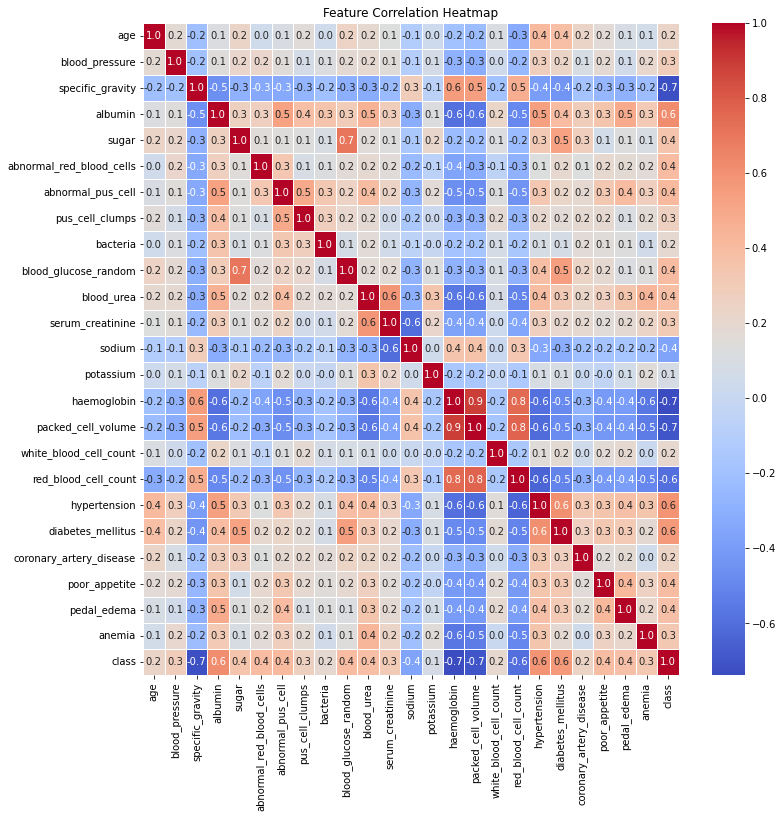

In [7]:
corr_matrix = df_clean.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
df_new = pd.read_csv('data/ckd-dataset-v2.csv')
df_new = df_new[2:].reset_index(drop = True)
df_new.columns = ['blood_pressure_diastolic', 'blood_pressure_limit', 'specific_gravity', 
                  'albumin', 'class_label', 'abnormal_red_blood_cells', 'sugar', 'abnormal_pus_cell',
                  'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'sodium', 
                  'serum_creatinine', 'potassium', 'haemoglobin', 'packed_cell_volume', 
                  'red_blood_cell_count', 'white_blood_cell_count', 'hypertension', 'diabetes_mellitus', 
                  'coronary_artery_disease', 'poor_appetite', 'pedal_edema', 'anemia', 'grf', 'stage',
                  'class', 'age']

df_new['blood_pressure_diastolic'] = pd.to_numeric(df_new['blood_pressure_diastolic'], errors='coerce')
df_new['abnormal_red_blood_cells'] = pd.to_numeric(df_new['abnormal_red_blood_cells'], errors='coerce')
df_new['abnormal_pus_cell'] = pd.to_numeric(df_new['abnormal_pus_cell'], errors='coerce')
df_new['pus_cell_clumps'] = pd.to_numeric(df_new['pus_cell_clumps'], errors='coerce')
df_new['bacteria'] = pd.to_numeric(df_new['bacteria'], errors='coerce')
df_new['hypertension'] = pd.to_numeric(df_new['hypertension'], errors='coerce')
df_new['diabetes_mellitus'] = pd.to_numeric(df_new['diabetes_mellitus'], errors='coerce')
df_new['coronary_artery_disease'] = pd.to_numeric(df_new['coronary_artery_disease'], errors='coerce')
df_new['poor_appetite'] = pd.to_numeric(df_new['poor_appetite'], errors='coerce')
df_new['pedal_edema'] = pd.to_numeric(df_new['pedal_edema'], errors='coerce')
df_new['anemia'] = pd.to_numeric(df_new['anemia'], errors='coerce')

def assign_blood_pressure(row):
    if row['blood_pressure_diastolic'] == 0:
        return '< 80'
    else:
        return '≥ 80'

df_new['blood_pressure'] = df_new.apply(assign_blood_pressure, axis=1)
df_new = df_new[df_clean.columns]
df_new.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,< 12,< 80,1.019 - 1.021,1 - 1,< 0,0,0,0,0,< 112,< 48.1,< 3.65,138 - 143,< 7.31,11.3 - 12.6,33.5 - 37.4,7360 - 9740,4.46 - 5.05,0,0,0,0,0,0,1
1,< 12,< 80,1.009 - 1.011,< 0,< 0,0,0,0,0,112 - 154,< 48.1,< 3.65,133 - 138,< 7.31,11.3 - 12.6,33.5 - 37.4,12120 - 14500,4.46 - 5.05,0,0,0,0,0,0,1
2,< 12,< 80,1.009 - 1.011,≥ 4,< 0,1,1,0,1,< 112,48.1 - 86.2,< 3.65,133 - 138,< 7.31,8.7 - 10,29.6 - 33.5,14500 - 16880,4.46 - 5.05,0,0,0,1,0,0,1
3,< 12,≥ 80,1.009 - 1.011,3 - 3,< 0,0,0,0,0,112 - 154,< 48.1,< 3.65,133 - 138,< 7.31,13.9 - 15.2,41.3 - 45.2,7360 - 9740,4.46 - 5.05,0,0,0,0,0,0,1
4,12 - 20,< 80,1.015 - 1.017,< 0,< 0,0,0,0,0,154 - 196,< 48.1,< 3.65,133 - 138,< 7.31,13.9 - 15.2,37.4 - 41.3,7360 - 9740,5.05 - 5.64,0,1,0,1,1,0,1


In [29]:
def kde_rejection_sampling(kde, train_values, lower_bound=None, upper_bound=None, n_samples=100, max_attempts=5):
    accepted_samples = []
    attempts = 0

    while len(accepted_samples) < 1 and attempts < max_attempts:
        x_samples = np.random.uniform(
            train_values.min() if lower_bound is None else lower_bound,
            train_values.max() if upper_bound is None else upper_bound,
            n_samples
        ).reshape(-1, 1)
        
        log_densities = kde.score_samples(x_samples)
        densities = np.exp(log_densities)
        
        probs = densities / densities.sum()
        
        accepted = np.random.choice(
            range(len(x_samples)), 
            size=min(5, len(x_samples)), 
            p=probs, 
            replace=False
        )

        for i in accepted:
            if (lower_bound is None or x_samples[i] >= lower_bound) and \
               (upper_bound is None or x_samples[i] <= upper_bound):
                accepted_samples.append(x_samples[i][0])

        attempts += 1
    
    selected = np.random.choice(accepted_samples)
    noise = np.random.normal(0, 0.001 * (train_values.max() - train_values.min()))
    return selected + noise

In [10]:
def synthesize_values(df_new, df_original, categorical_columns=None):
    df_result = df_new.copy()
    
    if categorical_columns is None:
        categorical_columns = []
        for col in df_new.columns:
            if col in df_clean.columns and pd.api.types.is_string_dtype(df_new[col]):
                sample_values = df_new[col].dropna().sample(min(5, len(df_new[col].dropna()))).values
                for val in sample_values:
                    if isinstance(val, str) and any(x in val for x in ['<', '>', '-', '≤', '≥']):
                        categorical_columns.append(col)
                        break
    
    for col in categorical_columns:
        if col not in df_original.columns:
            print(f"Warning: No column {col} in original dataframe, skipping.")
            continue
            
        train_values = df_original[col].dropna().values.reshape(-1, 1)
        if len(train_values) == 0:
            print(f"Warning: No training values for column {col}, skipping.")
            continue
            
        kde = KernelDensity(kernel='gaussian', bandwidth=np.std(train_values) * 0.3).fit(train_values)
        
        for i in df_result.index:
            value = df_result.loc[i, col]
            
            if not isinstance(value, str):
                continue
            
            lower_bound = None
            upper_bound = None
            
            if '-' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if len(parts) >= 2:
                    lower_bound = float(parts[0])
                    upper_bound = float(parts[1])
            elif '<' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if parts:
                    upper_bound = float(parts[0]) - 1e-10
            elif '>' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if parts:
                    lower_bound = float(parts[0]) + 1e-10
            elif '≤' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if parts:
                    upper_bound = float(parts[0])
            elif '≥' in value:
                parts = re.findall(r'([\d\.]+)', value)
                if parts:
                    lower_bound = float(parts[0])
            
            df_result.loc[i, col] = kde_rejection_sampling(kde, train_values, lower_bound, upper_bound)
    
    return df_result.astype(np.float64)

In [11]:
df_new_samples = synthesize_values(df_new, df_clean)

In [12]:
def set_column_dtypes(df, dtype_map):
    for col, dtype in dtype_map.items():
        if col in df.columns:
            try:
                df[col] = df[col].astype(dtype)
            except Exception as e:
                print(f"Could not convert column '{col}' to {dtype}: {e}")
        else:
            print(f"Column '{col}' not found in DataFrame.")
    return df

dtype_map = {
    'age': 'int',
    'blood_pressure': 'float64',
    'specific_gravity': 'float64',
    'albumin': 'int',
    'sugar': 'int',
    'abnormal_red_blood_cells': 'int',
    'abnormal_pus_cell': 'int',
    'pus_cell_clumps': 'int',
    'bacteria': 'int',
    'blood_glucose_random': 'float64',
    'blood_urea': 'int',
    'serum_creatinine': 'float64',
    'sodium': 'int',
    'potassium': 'float64',
    'haemoglobin': 'int',
    'packed_cell_volume': 'int',
    'white_blood_cell_count': 'int',
    'red_blood_cell_count': 'int',
    'hypertension': 'int',
    'diabetes_mellitus': 'int',
    'coronary_artery_disease': 'int',
    'poor_appetite': 'int',
    'pedal_edema': 'int',
    'anemia': 'int',
    'class': 'int'
}

df_clean = set_column_dtypes(df_clean, dtype_map)
df_new_samples = set_column_dtypes(df_new_samples, dtype_map)

In [13]:
df_new_samples.head()

,age,blood_pressure,specific_gravity,albumin,sugar,abnormal_red_blood_cells,abnormal_pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,poor_appetite,pedal_edema,anemia,class
0,4,74.743559,1.020143,1,0,0,0,0,0,109.412021,26,1.500782,140,6.137326,12,36,7619,4,0,0,0,0,0,0,1
1,6,66.927577,1.009819,0,0,0,0,0,0,130.006940,47,3.234069,137,3.648753,11,35,12890,4,0,0,0,0,0,0,1
2,7,62.589398,1.009343,4,0,1,1,0,1,54.235311,48,1.458361,133,4.036894,9,33,15473,4,0,0,0,1,0,0,1
3,10,84.243047,1.010225,2,0,0,0,0,0,121.922065,38,1.114743,135,3.917716,14,43,9369,4,0,0,0,0,0,0,1
4,18,62.530550,1.016889,0,0,0,0,0,0,163.628396,20,2.527452,135,5.662735,14,41,8672,5,0,1,0,1,1,0,1


/Users/jeffwang/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/jeffwang/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


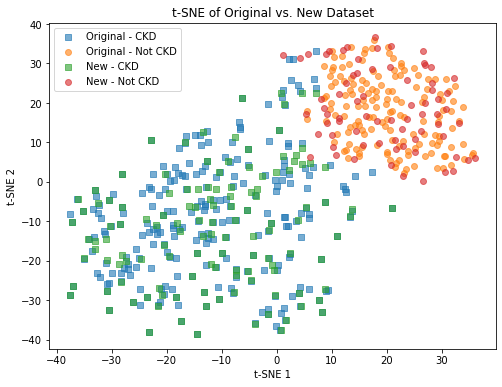

In [30]:
df_clean['source'] = 'Original'
df_new_samples['source'] = 'New'
combined = pd.concat([df_clean, df_new_samples], ignore_index=True)

class_labels = combined['class']
combined = combined.drop(columns=['class'])

features = combined.drop(columns=['source'])
numeric_cols = features.select_dtypes(include=[np.number]).columns
X = combined[numeric_cols].values

X = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_reduced = tsne.fit_transform(X)

reduced_df = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2'])
reduced_df['source'] = combined['source'].values
reduced_df['class'] = class_labels.values

plt.figure(figsize=(8, 6))
markers = {0: 'o', 1: 's'}

for source in reduced_df['source'].unique():
    for cls in reduced_df['class'].unique():
        subset = reduced_df[(reduced_df['source'] == source) & (reduced_df['class'] == cls)]
        class_label = 'CKD' if cls == 1 else 'Not CKD'
        plt.scatter(subset['Dim1'], subset['Dim2'],
                    label=f'{source} - {class_label}',
                    marker=markers.get(cls, 'x'), alpha=0.6)

plt.title(f't-SNE of Original vs. New Dataset')
plt.xlabel(f't-SNE 1')
plt.ylabel(f't-SNE 2')
plt.legend()
plt.show()

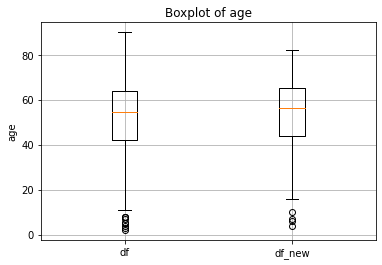

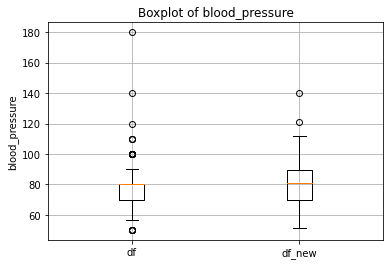

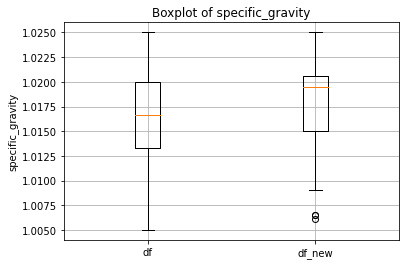

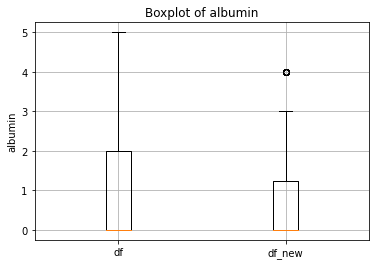

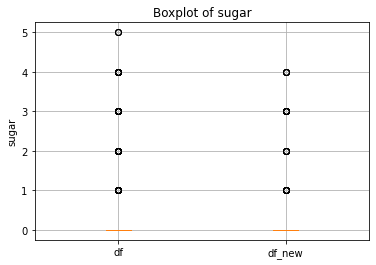

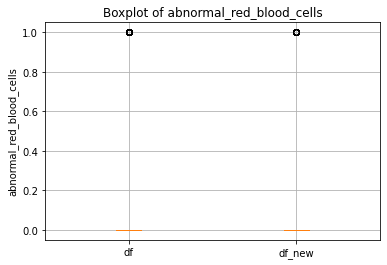

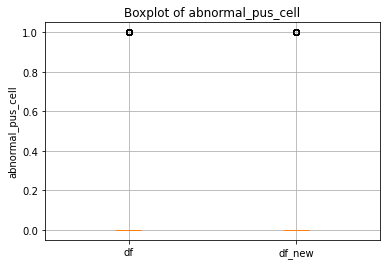

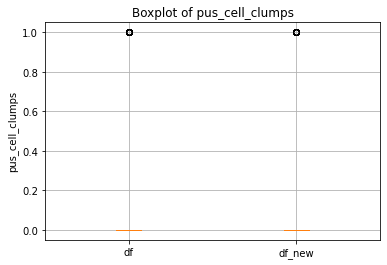

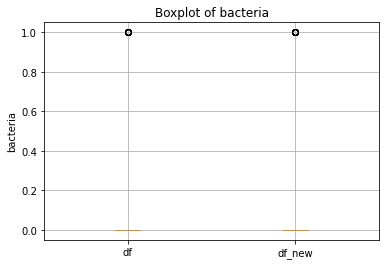

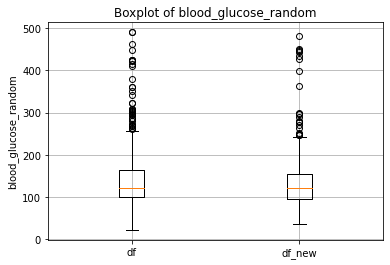

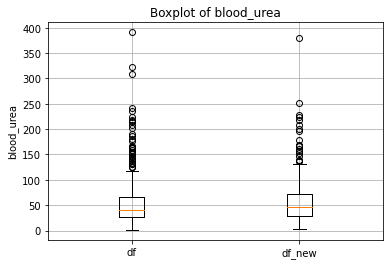

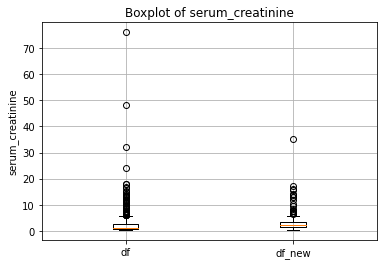

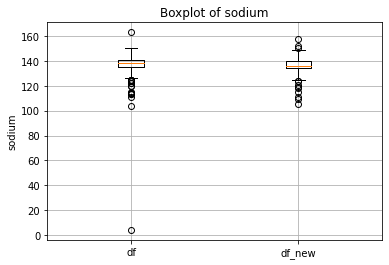

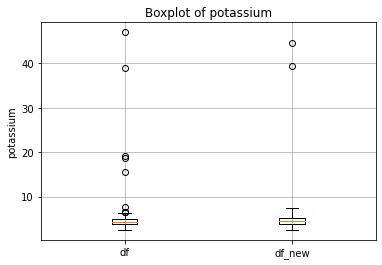

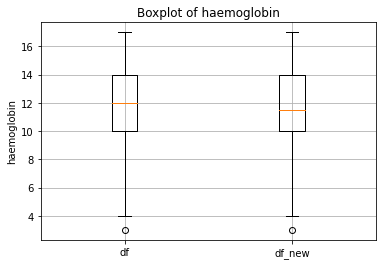

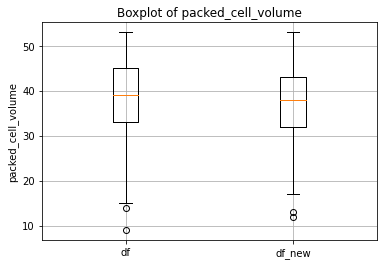

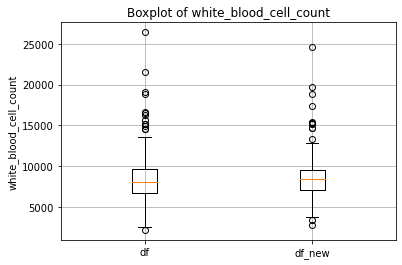

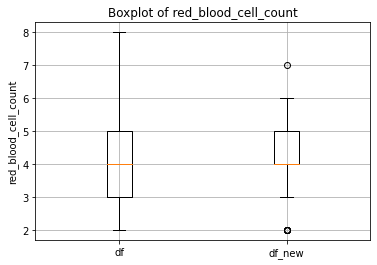

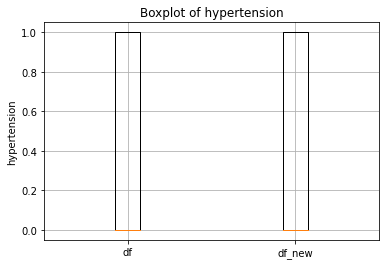

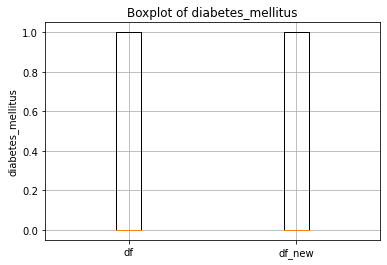

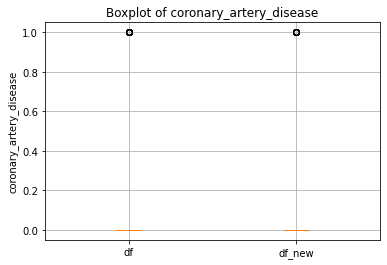

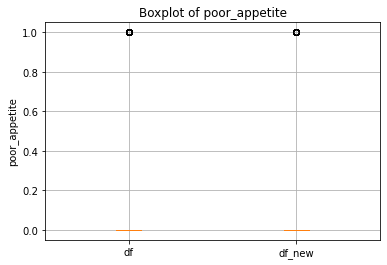

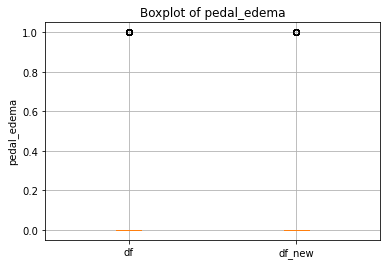

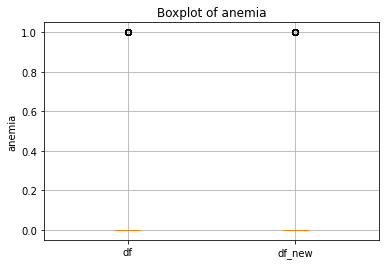

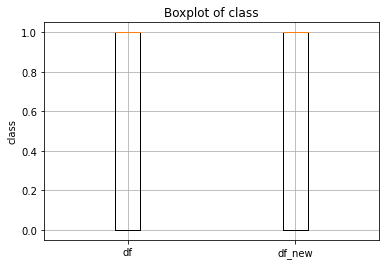

In [22]:
common_cols = df_clean.select_dtypes(include=[np.number]).columns.intersection(df_new_samples.columns)
    
for col in common_cols:
    plt.figure(figsize=(6, 4))
    plt.boxplot([df_clean[col].dropna(), df_new_samples[col].dropna()], labels=['df', 'df_new'])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

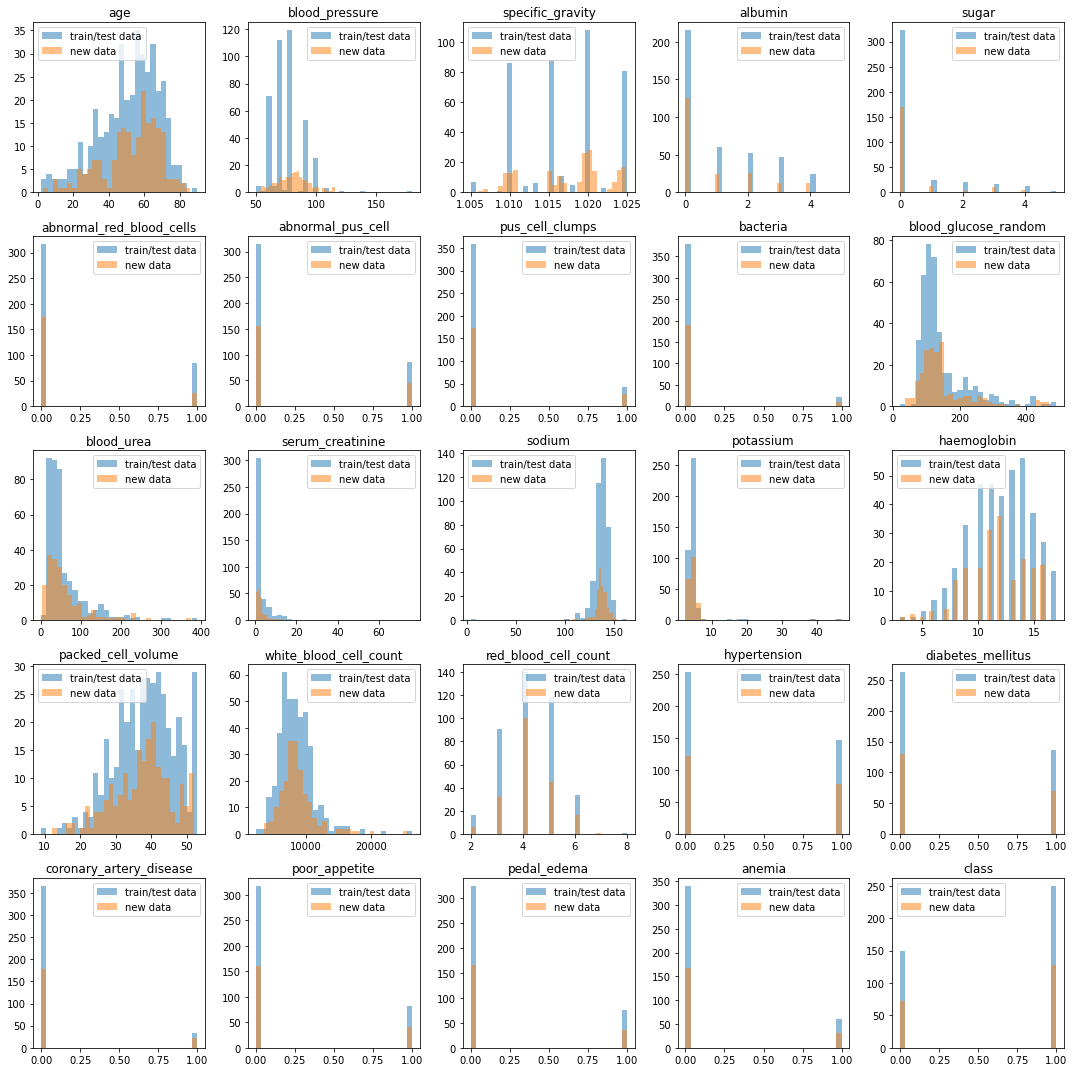

In [196]:
fig, axis = plt.subplots(5, 5, figsize=(15, 15))
axis = axis.flatten()

for i, col in enumerate(df_clean.columns):
    ax = axis[i]
    ax.hist(df_clean[col], bins=30, alpha=0.5, label='train/test data')
    ax.hist(df_new_samples[col], bins=30, alpha=0.5, label='new data')
    ax.set_title(col)
    ax.legend()

plt.tight_layout()
plt.show()

In [28]:
df_clean["class"].value_counts()

1    250
0    150
Name: class, dtype: int64

In [33]:
df_new["class"].value_counts()

1    128
0     72
Name: class, dtype: int64